# Boosting

<div style="border: 2px solid #2c3e50; 
            padding: 15px; 
            border-radius: 8px; 
            background-color: #e8f8f5; 
            color: #2c3e50; 
            font-family: 'Segoe UI', Tahoma, sans-serif; 
            box-shadow: 2px 2px 6px rgba(0,0,0,0.1);">

<h3 style="color:#117864;">Notebook Intro</h3>

<p>
This notebook introduces boosting, an ensemble learning technique that turns weak learners into a strong predictive model.
 It explains the mathematics of AdaBoost in detail, then demonstrates the process step by step with a simple numerical example and
 visualizations. As part of the series, 
it builds the theoretical foundation needed to understand modern gradient boosting libraries like XGBoost and LightGBM.
</p>

</div>

## Boosting in Machine Learning

Boosting is an **ensemble learning technique** that combines multiple **weak learners** sequentially to form a **strong learner**. At each step, the algorithm focuses more on the errors made by previous models, effectively "boosting" performance.

---

###  Key Idea

> *Each new model improves upon the mistakes of the previous one.*

---

###  Scope of Boosting

Boosting is widely used for:

- Classification (binary/multiclass)
- Regression tasks
- Ranking problems (e.g., XGBoost in Kaggle)
- Handling imbalanced data
- Interpretable models (e.g., shallow tree stumps)

---

###  How It Works

1. Start with equal weights on training samples.
2. Train a weak learner (e.g., decision stump).
3. Compute the **error** of the model.
4. Increase weights on misclassified samples.
5. Train the next learner focusing more on the hard cases.
6. Repeat for **T** rounds.
7. Final model is a **weighted vote** of all learners.

---

###  Types of Boosting

| Type             | Key Features                                      |
|------------------|---------------------------------------------------|
| **AdaBoost**     | Adjusts sample weights based on misclassifications. |
| **Gradient Boosting** | Learns by minimizing a loss function using gradient descent. |
| **XGBoost**      | Optimized, regularized version of Gradient Boosting. |
| **LightGBM**     | Histogram-based faster version for large datasets. |
| **CatBoost**     | Handles categorical variables automatically.       |

---




## AdaBoost: Mathematical Foundation


###  Problem Setup

Given training data:

$$
\{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}, \quad y_i \in \{-1, +1\}
$$

Each data point has an associated weight $w_i^{(t)}$ at iteration $t$, initialized as:

$$
w_i^{(1)} = \frac{1}{n}
$$

---

###  Boosting Iteration (for $t = 1$ to $T$)

1. **Train Weak Learner**  
   Train weak hypothesis $h_t(x)$ using weights $w_i^{(t)}$.

2. **Calculate Weighted Error**:

$$
\epsilon_t = \sum_{i=1}^{n} w_i^{(t)} \cdot \mathbb{1}(h_t(x_i) \ne y_i)
$$

3. **Compute Model Weight (Confidence)**:

$$
\alpha_t = \frac{1}{2} \ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
$$

4. **Update Sample Weights**:

$$
w_i^{(t+1)} = w_i^{(t)} \cdot e^{-\alpha_t y_i h_t(x_i)}
$$

Normalize:

$$
w_i^{(t+1)} \leftarrow \frac{w_i^{(t+1)}}{\sum_{j=1}^{n} w_j^{(t+1)}}
$$

---

###  Final Strong Classifier

$$
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)
$$

---

###  Interpretation

- $ \alpha_t $ determines how much influence each weak learner has.
- Larger $ \alpha_t $ means the learner is more accurate and gets a stronger vote.
- The update rule increases focus on misclassified points.
- Learners with $ \epsilon_t \geq 0.5 $ are either discarded or reversed.

---

###  Convergence Requirement

Each weak learner must perform slightly better than chance:

$$
\epsilon_t < 0.5 \quad \text{for all } t
$$

---

### Summary

AdaBoost creates a strong classifier by **additively combining** many weak ones, each successively improving on the errors of the previous, guided by an exponential weighting scheme.


In [ ]:
import numpy as np
import pandas as pd
# ---------------------------------------
# Step 0: Dataset (labels in {0, 1})
# ---------------------------------------
# Original labels: 1 = pass, 0 = fail
X = np.array([1, 2, 3])
y_binary = np.array([1, 1, 0])
print(pd.DataFrame(X,y_binary))
# Convert to AdaBoost-style: y ∈ {-1, +1}
# Formula: y = 2 * y_binary - 1
# So: 1 → +1, 0 → -1
y = 2 * y_binary - 1

# ---------------------------------------
# Initialize sample weights
# All weights start equal: w_i^(1) = 1/n
# ---------------------------------------
n = len(X)
w = np.full(n, 1/n)  # w = [1/3, 1/3, 1/3]

# ---------------------------------------
# Define weak learners (stumps)
# ---------------------------------------
def stump_1(x):
    # h1(x): predicts +1 for all inputs
    return np.ones_like(x)

def stump_2(x):
    # h2(x): separates first point
    return np.where(x < 1.5, 1, -1)

# ---------------------------------------
# Round 1 — Train h1
# ---------------------------------------
h1 = stump_1(X)

# Error indicator: I(h1(x_i) ≠ y_i)
misses1 = (h1 != y).astype(int)

# Weighted error: ε₁ = ∑ w_i * I(h(x_i) ≠ y_i)
epsilon1 = np.sum(w * misses1)

# Alpha (model weight): α₁ = (1/2) * log((1 - ε₁)/ε₁)
alpha1 = 0.5 * np.log((1 - epsilon1) / epsilon1)

# Update weights:
# w_i ← w_i * exp(-α₁ * y_i * h₁(x_i))
w = w * np.exp(-alpha1 * y * h1)
w = w / np.sum(w)  # Normalize

print(" Round 1")
print(f"Predictions:     {h1}")
print(f"Actual labels:   {y}")
print(f"Misclassified:   {misses1}")
print(f"Weighted Error ε₁: {epsilon1:.3f}")
print(f"Alpha₁:           {alpha1:.3f}")
print(f"Updated Weights: {np.round(w, 3)}\n")

# ---------------------------------------
# Round 2 — Train h2
# ---------------------------------------
h2 = stump_2(X)
misses2 = (h2 != y).astype(int)
epsilon2 = np.sum(w * misses2)
alpha2 = 0.5 * np.log((1 - epsilon2) / epsilon2)

# No update needed since this is final round

print(" Round 2")
print(f"Predictions:     {h2}")
print(f"Actual labels:   {y}")
print(f"Misclassified:   {misses2}")
print(f"Weighted Error ε₂: {epsilon2:.3f}")
print(f"Alpha₂:           {alpha2:.3f}\n")

# ---------------------------------------
# Final AdaBoost Prediction
# H(x) = sign(α₁·h₁(x) + α₂·h₂(x))
# ---------------------------------------
combined = alpha1 * h1 + alpha2 * h2
final_pred = np.sign(combined)

print(" Final AdaBoost Prediction:")
for i in range(n):
    print(f"Sample {i+1}: Score = {combined[i]:.2f}, Predicted = {int(final_pred[i])}, Actual = {y[i]}")


   0
1  1
1  2
0  3
 Round 1
Predictions:     [1 1 1]
Actual labels:   [ 1  1 -1]
Misclassified:   [0 0 1]
Weighted Error ε₁: 0.333
Alpha₁:           0.347
Updated Weights: [0.25 0.25 0.5 ]

 Round 2
Predictions:     [ 1 -1 -1]
Actual labels:   [ 1  1 -1]
Misclassified:   [0 1 0]
Weighted Error ε₂: 0.250
Alpha₂:           0.549

 Final AdaBoost Prediction:
Sample 1: Score = 0.90, Predicted = 1, Actual = 1
Sample 2: Score = -0.20, Predicted = -1, Actual = 1
Sample 3: Score = -0.20, Predicted = -1, Actual = -1


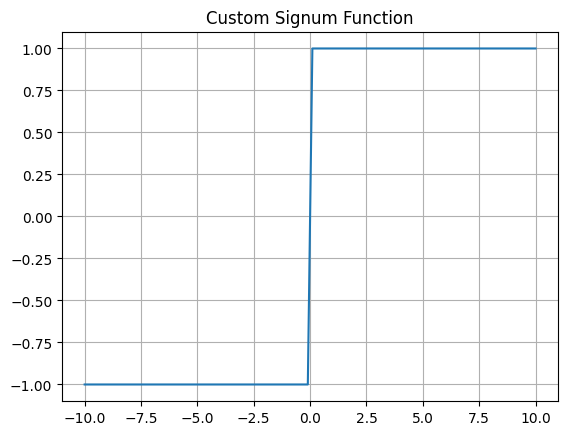

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def signum(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

x = np.linspace(-10, 10, 100)
y = signum(x)

plt.plot(x, y)
plt.title("Custom Signum Function")
plt.grid(True)
plt.show()


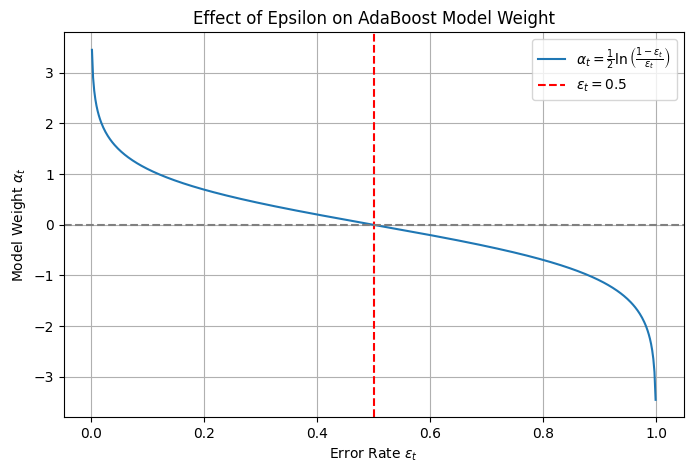

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create epsilon values just above 0 up to 1
epsilons = np.linspace(0.001, 0.999, 500)
alphas = 0.5 * np.log((1 - epsilons) / epsilons)

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(epsilons, alphas, label=r"$\alpha_t = \frac{1}{2} \ln\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$")
plt.axvline(0.5, color='red', linestyle='--', label=r"$\epsilon_t = 0.5$")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Effect of Epsilon on AdaBoost Model Weight")
plt.xlabel(r"Error Rate $\epsilon_t$")
plt.ylabel(r"Model Weight $\alpha_t$")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Step 0: Dataset
X = np.array([1, 2, 3])
y = np.array([1, 1, -1])   # Labels must be +1 or -1

# Initialize weights
w = np.full(len(X), 1/len(X))  # w = [1/3, 1/3, 1/3]

def stump_1(x):
    """Weak classifier 1"""
    return np.where(x < 2.5, 1, 1)  # Forces misclassification of sample 3

def stump_2(x):
    """Weak classifier 2"""
    return np.where(x < 1.5, 1, -1)

# --- ROUND 1 ---
h1 = stump_1(X)
misses1 = (h1 != y).astype(int)
epsilon1 = np.sum(w * misses1)

alpha1 = 0.5 * np.log((1 - epsilon1) / epsilon1)

# Update weights
w_new = w * np.exp(-alpha1 * y * h1)
w = w_new / np.sum(w_new)  # Normalize

print("Round 1:")
print(f"Predictions: {h1}")
print(f"Errors: {misses1}")
print(f"Error Rate (epsilon1): {epsilon1:.3f}")
print(f"Alpha1: {alpha1:.3f}")
print(f"Updated Weights: {np.round(w, 3)}\n")

# --- ROUND 2 ---
h2 = stump_2(X)
misses2 = (h2 != y).astype(int)
epsilon2 = np.sum(w * misses2)
alpha2 = 0.5 * np.log((1 - epsilon2) / epsilon2)

# No further weight update since it's last round

print("Round 2:")
print(f"Predictions: {h2}")
print(f"Errors: {misses2}")
print(f"Error Rate (epsilon2): {epsilon2:.3f}")
print(f"Alpha2: {alpha2:.3f}\n")

# --- Final Model ---
# Combine predictions
final = alpha1 * h1 + alpha2 * h2
final_prediction = np.sign(final)

print("Final AdaBoost Prediction:")
for i in range(len(X)):
    print(f"Sample {i+1}: Raw Score = {final[i]:.2f}, Predicted = {int(final_prediction[i])}, Actual = {y[i]}")


Round 1:
Predictions: [1 1 1]
Errors: [0 0 1]
Error Rate (epsilon1): 0.333
Alpha1: 0.347
Updated Weights: [0.25 0.25 0.5 ]

Round 2:
Predictions: [ 1 -1 -1]
Errors: [0 1 0]
Error Rate (epsilon2): 0.250
Alpha2: 0.549

Final AdaBoost Prediction:
Sample 1: Raw Score = 0.90, Predicted = 1, Actual = 1
Sample 2: Raw Score = -0.20, Predicted = -1, Actual = 1
Sample 3: Raw Score = -0.20, Predicted = -1, Actual = -1


# Parameters of AdaBoostClassifier

| Parameter       | Type   | Default     | Description                                                                                                                   |
| --------------- | ------ | ----------- | ----------------------------------------------------------------------------------------------------------------------------- |
| `estimator`     | object | `None`      | The base estimator (weak learner). Most commonly: `DecisionTreeClassifier(max_depth=1)`.                                      |
| `n_estimators`  | int    | `50`        | Number of weak learners to train sequentially. More = better accuracy, risk of overfitting.                                   |
| `learning_rate` | float  | `1.0`       | Shrinks the contribution of each learner (like step size in gradient descent). Common values: 0.01, 0.1, 1.0                  |
| `algorithm`     | str    | `'SAMME.R'` | `'SAMME'` (discrete AdaBoost) or `'SAMME.R'` (real boosting using probability scores). `'SAMME.R'` is smoother and preferred. |
| `random_state`  | int    | `None`      | Seed for reproducibility of the boosting process.                                                                             |


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import datasets
from sklearn import preprocessing

iris_data = datasets.load_iris()

X = iris_data.data
y= iris_data.target

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

model = AdaBoostClassifier(n_estimators=100,learning_rate=0.1,random_state=123)

model.fit(X_train,y_train)

y_prediction = model.predict(X_test)

print(confusion_matrix(y_test,y_prediction))
print(accuracy_score(y_test,y_prediction))

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
1.0


In [ ]:
param_dist = {
    'n_estimators':[10,50,200],
    'learning_rate':[0.01,0.05,0.3,1]
}

estimator =AdaBoostClassifier()
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_dist,cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

AdaBoostClassifier(learning_rate=0.05, n_estimators=200)


[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


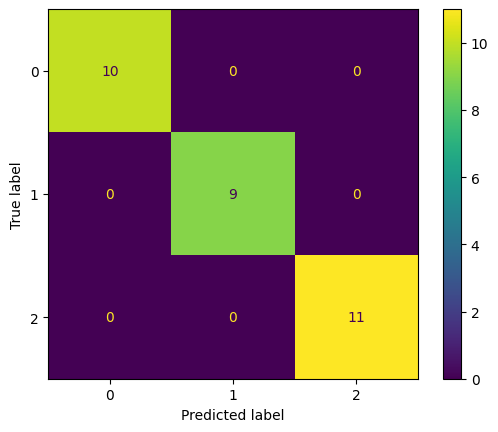

In [ ]:
print(grid_search.predict(X_test))

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,grid_search.predict(X_test))

In [ ]:
import pandas as pd
wine_data = datasets.load_wine()
X=wine_data.data
y=wine_data.target

print(wine_data.target_names)
df = pd.DataFrame(data=y)
df.head(100)

['class_0' 'class_1' 'class_2']


,0
0,0
1,0
2,0
3,0
4,0
...,...
95,1
96,1
97,1
98,1
